# Figure 3 Plotting

In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size":24})

In [5]:
from datetime import datetime

In [6]:
def formatted_datetime_now():
    return datetime.strftime(datetime.now(), format='%d%m%y%H%M')

In [7]:
def formatted_date_now():
    return datetime.strftime(datetime.now(), format='%d/%m/%y')

## Load machine data

In [8]:
save_path = './tev_data/'

In [9]:
processor = 'rainbow'

### Load run run

In [10]:
save_file_path = save_path + '2211212155_run.pickle'

with open(save_file_path, 'rb') as savefile:
    data = pickle.load(savefile)

In [11]:
machine = data['machine']

In [12]:
means = np.array([value['mean'] for _, value in sorted(machine.items())])
id_means = np.array([value['mean_id'] for _, value in sorted(machine.items())])
sigma_c = np.array([value['std'] for _, value in sorted(machine.items())])
sigma_id = np.array([value['std_id'] for _, value in sorted(machine.items())])
ns = [int(k) for k, _ in sorted(machine.items())]

In [13]:
if 'processor' in data.keys():
    processor = data['processor']

In [14]:
print(processor)

rainbow


In [15]:
print(means)
print(id_means)

[0.49759 0.4408  0.3152  0.1609  0.10101 0.05108 0.01594 0.00598 0.00397]
[0.82972 0.83042 0.76086 0.57603 0.51656 0.25885 0.12066 0.06501 0.04118]


## Calculate the exact overlap

In [15]:
import sys
sys.path.append('../src/')

In [16]:
import overlaps_classical as oc
from circuits import StateAnsatz

In [17]:
print(data['θ_A'], '\n', data['θ_B'])

[0.41104574 0.76466907 0.01060491 0.98798927] 
 [0.45796046 1.19586014 0.26073793 1.41905342]


In [18]:
print(data['ψ_A'], '\n', data['ψ_B'])

None 
 None


In [19]:
overlap = oc.exact_overlap(data['θ_A'], data['θ_B'], ab=True, all_evals=True, Ansatz=StateAnsatz)

In [20]:
overlap

array([0.83825508, 0.25870911, 0.11214486, 0.05600795])

In [21]:
overlap_sq = overlap ** 2
print(overlap_sq)

[0.70267157 0.0669304  0.01257647 0.00313689]


## Curvefit

In [22]:
from scipy.optimize import curve_fit
from copy import copy

In [23]:
p = np.polyfit(ns, id_means, 3)

In [24]:
n_ls = np.linspace(min(ns), max(ns), 100)

In [25]:
def fit_ps(p, xs):
    ys = np.zeros(xs.shape)
    for i, p in enumerate(reversed(p)):
        ys += p*xs**i
    return ys

In [26]:
def cubic_poly(p, x):
    return p[0]*x**3 + p[1]*x**2 + p[2]*x + p[3]

In [27]:
ys = fit_ps(p, n_ls)
#ys_correct = cubic_poly(p, n_ls)

Could try linearly interpolating between point 5, 6

In [28]:
from scipy.interpolate import interp1d

In [29]:
print(id_means)
mask = np.ones(len(id_means), dtype=bool)
mask[4] = False
print(id_means[mask])

[0.82972 0.83042 0.76086 0.57603 0.51656 0.25885 0.12066 0.06501 0.04118]
[0.82972 0.83042 0.76086 0.57603 0.25885 0.12066 0.06501 0.04118]


In [30]:
id_means_corr = id_means[mask]
ns_corr = np.array(ns)[mask]

In [31]:
f = interp1d(ns_corr, id_means_corr)
f_cubic = interp1d(ns_corr, id_means_corr, kind='cubic')
f_quadratic = interp1d(ns_corr, id_means_corr, kind='quadratic')

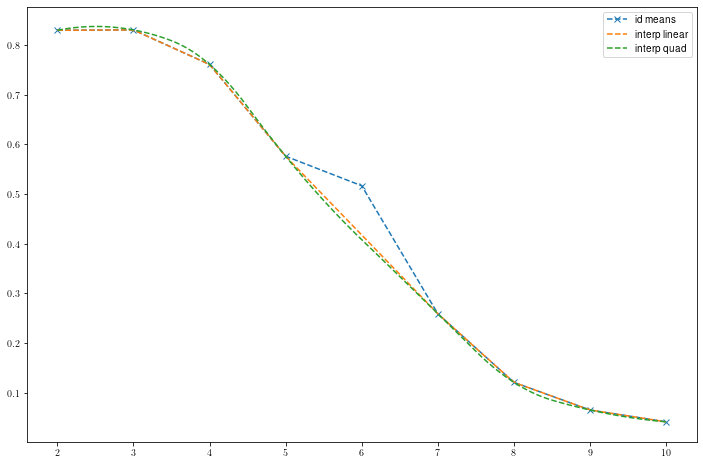

In [32]:
fig = plt.figure(figsize=(12, 8))
plt.plot(ns, id_means, 'x--', label='id means')
plt.plot(n_ls, f(n_ls), '--', label='interp linear')
plt.plot(n_ls, f_quadratic(n_ls), '--', label='interp quad')
plt.legend()
plt.show()

In [36]:
ns_corr = np.array(ns)[mask]
means_corr = means[mask]

f_quadratic_means = interp1d(ns_corr, means_corr)

In [37]:
id_means_corr = copy(id_means)
id_means_corr[4] = f_quadratic(ns[4])
means_corr = copy(means)
means_corr[4] = f_quadratic_means(ns[4])

## Plot figures

In [38]:
save_fig=False

In [39]:
def calculate_ratio_error(Ci, sigma_Ci):
    ratios = Ci[1:]/ Ci[:-1]
    return ratios * np.sqrt( (sigma_Ci[1:]/Ci[1:])**2 + (sigma_Ci[:-1]/Ci[:-1])**2 )

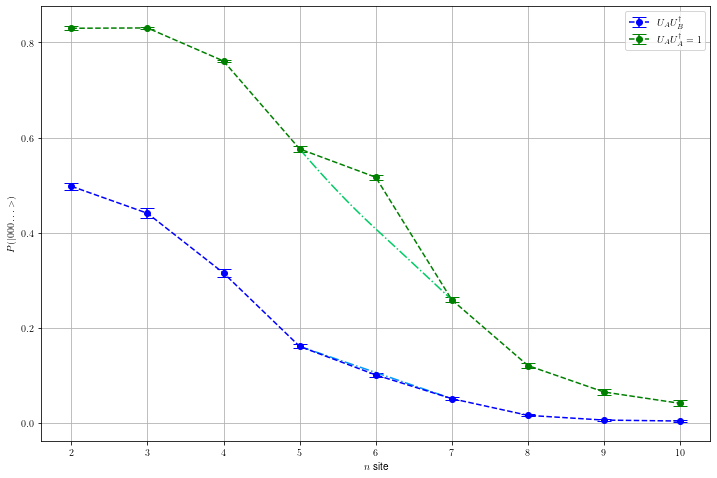

In [40]:
fig = plt.figure(figsize=(12, 8))
plt.errorbar(ns, means, yerr=sigma_c, label='$U_A U_B^\dagger$', color='b', ecolor='b', linestyle='--', marker='o', capsize=7.0)
plt.errorbar(ns, id_means, yerr=sigma_id, label='$U_A U_A^\dagger = 1$', color='g', ecolor='g', linestyle='--', marker='o', capsize=7.0)
#plt.title('{} Probability 0 for n site'.format(processor, formatted_date_now()))
plt.xlabel('$n$ site')
plt.ylabel(r'$P(|000\dots>)$')
plt.grid()
plt.legend()

# Add corrections to the id curve
ns_corr = np.linspace(5, 7, 50)
id_m_corr = f_quadratic(ns_corr)
plt.plot(ns_corr, id_m_corr, '-.', color='#00cc66')
plt.plot(ns_corr, f_quadratic_means(ns_corr), '-.', color='#0099ff')
if save_fig:
    plt.savefig('figures/{}_ci_measure_{}.png'.format(processor, formatted_datetime_now()))

In [41]:
rescaled_means = means/id_means
rescaled_ratios = rescaled_means[1:]/rescaled_means[:-1]

In [42]:
sigma_rescaled = rescaled_means*np.sqrt( (sigma_c/means)**2 + (sigma_id/id_means)**2 )
sigma_resc_ratio = rescaled_ratios*np.sqrt( (sigma_rescaled[1:]/rescaled_means[1:])**2 + (sigma_rescaled[:-1]/rescaled_means[:-1])**2 )

In [43]:
# Correct the 6th point
corr_rescaled_6 = means_corr[4] / id_means_corr[4]
corr_ratio_6 = rescaled_means[5] / corr_rescaled_6

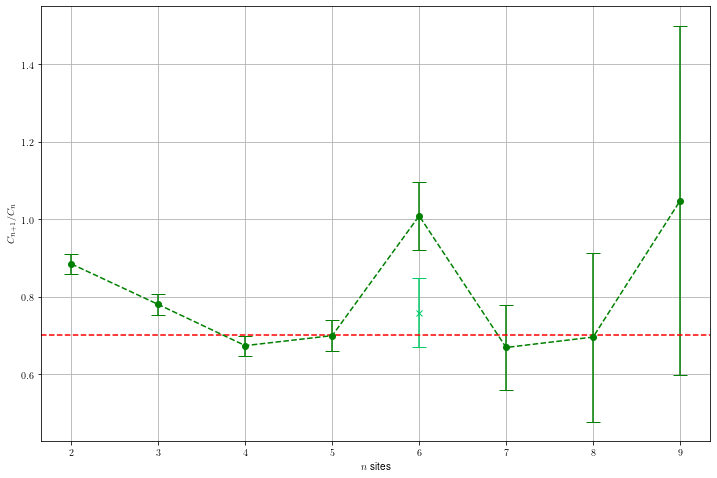

In [44]:
figure = plt.figure(figsize=(12, 8))
plt.errorbar(ns[:-1], rescaled_ratios, color='g', yerr=sigma_resc_ratio, ecolor='green', linestyle='--', marker='o', capsize=7.0)
plt.errorbar(6, corr_ratio_6, marker='x', color='#00cc66', yerr=sigma_resc_ratio[4], capsize=7.0)
plt.axhline(overlap_sq[0], color='r', ls='--')
plt.ylabel(r'$C_{n+1}/C_n$')
plt.xlabel(r'$n$ sites')
plt.grid()
# plt.title(r'Estimating overlap - {}'.format(processor))
if save_fig:
    plt.savefig('figures/{}_lambda_sq_{}.png'.format(processor, formatted_datetime_now()))
plt.show()

## Optimising Overlap Plot

In [45]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size":22})

In [46]:
save_path = './tev_data/'

save_file_path = save_path + '0212211151__optimisation_machine.pickle'

with open(save_file_path, 'rb') as savefile:
    data = pickle.load(savefile)

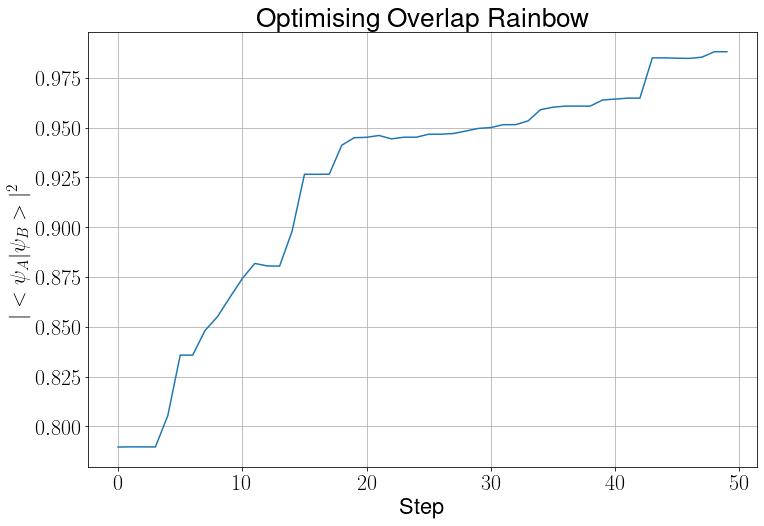

In [47]:
plt.figure(figsize=(12, 8))
plt.xlabel('Step')
plt.ylabel(r'$|<\psi_A | \psi_B>|^2$')
plt.title('Optimising Overlap Rainbow')
plt.plot(data['analytic'])
plt.grid()

# Figure 5 Plotting

In [54]:
times_paper, ls_paper = np.load('./tev_data/270122111200_paper.npy', allow_pickle=True)
times_xz_50, _, ls_xz_50 = np.load('./tev_data/270122105932_stateansatzxz_50.npy', allow_pickle=True)
times_UUprime_post_25, _, ls_xz_UUprime_post_25 = np.load('./tev_data/160222110630_halft_xz_25_exact_post_lambda2.npy', allow_pickle=True)

In [55]:
vlines = [0.0, 0.2, 0.6, 0.4, 0.8]

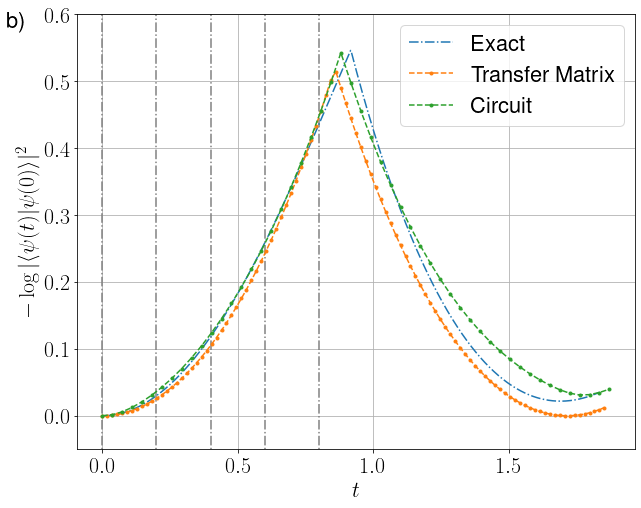

In [56]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()

plt.vlines(vlines, -0.2, 0.7, ls='-.', color='gray')
plt.plot(times_paper, ls_paper, '-.', label='Exact')
plt.plot(times_xz_50, ls_xz_50, '.--', label='Transfer Matrix')
plt.plot(times_UUprime_post_25, ls_xz_UUprime_post_25, '.--', label='Circuit')
plt.ylim(-0.05, 0.6)
plt.ylabel('$-\log|\langle\psi(t) | \psi(0) \\rangle |^2$')
plt.xlabel('$t$')
plt.grid()

plt.legend()
ax.annotate('b)', xy=(-0.35, 0.58), xycoords='data', annotation_clip=False)
#plt.savefig('../fig3/UUprime_post2_n2.pdf')
plt.show()